In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch
device = torch.device('mps')
print(device)


mps


In [5]:
# We load the dataset
train = pd.read_csv('dataset/twitter_training.csv')
test = pd.read_csv('dataset/twitter_validation.csv')


In [6]:
# Initial data exploration
# print(train.head())
# We add column names to the dataset
train.columns = ['id', 'genre', 'label', 'tweet']
test.columns = ['id', 'genre', 'label', 'tweet']
# Print column names
print(train.columns)

train.head()


Index(['id', 'genre', 'label', 'tweet'], dtype='object')


,id,genre,label,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


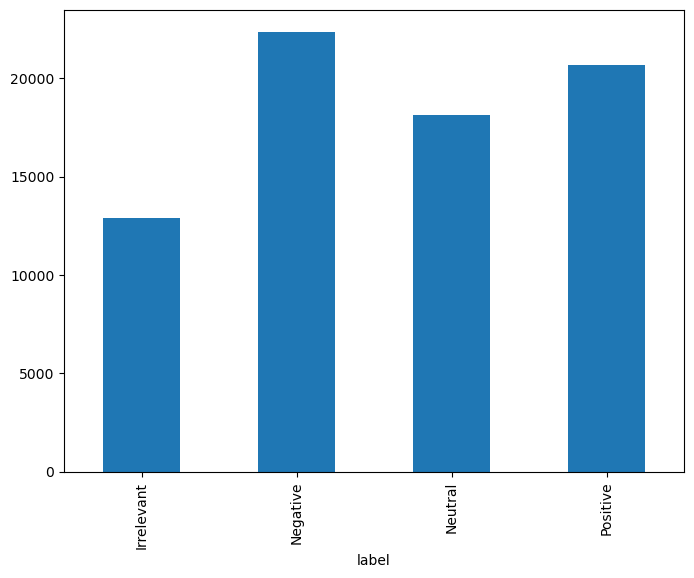

In [7]:
# We make a bar graph of the label frequencies
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('label').tweet.count().plot.bar(ylim=0)
plt.show()


In [8]:
# We find the max tweet length
max_len = train.tweet.str.len().max()
print('Max tweet length: ', max_len)


Max tweet length:  957.0


Number of genres:  32


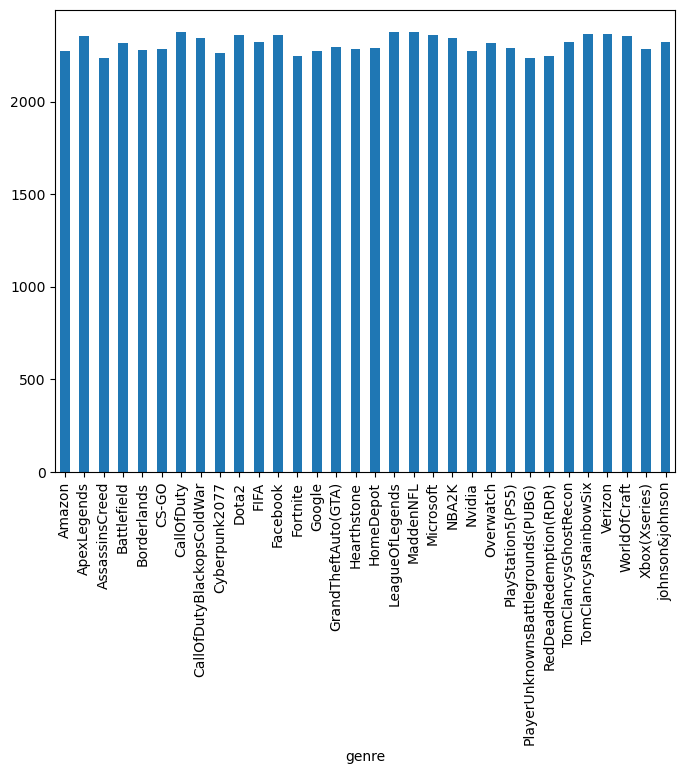

In [9]:
# We count the number of seperate genres and make a bar graph
print('Number of genres: ', train.genre.nunique())
fig = plt.figure(figsize=(8,6))
train.groupby('genre').tweet.count().plot.bar(ylim=0)
plt.show()




In [10]:
# We look for missing values
print('Missing values in training data: ')
print(train.isnull().sum())
print('Missing values in test data: ')
print(test.isnull().sum())



Missing values in training data: 
id         0
genre      0
label      0
tweet    686
dtype: int64
Missing values in test data: 
id       0
genre    0
label    0
tweet    0
dtype: int64


In [11]:
# We remove missing values
train = train.dropna()
test = test.dropna()
print('Missing values in training data: ')
print(train.isnull().sum())
print('Missing values in test data: ')
print(test.isnull().sum())


Missing values in training data: 


id       0
genre    0
label    0
tweet    0
dtype: int64
Missing values in test data: 
id       0
genre    0
label    0
tweet    0
dtype: int64


In [12]:
from transformers import BertModel
import torch
model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa").to(device)

In [13]:
# We import the tokenizer, tokenize a single example and run it through the model to see the output dimensions
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
example = train.tweet.iloc[0]
print('Example tweet: ', example)
encoded_input = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(**encoded_input)
print('Output dimensions: ', output.last_hidden_state.dtype)
print('CLS token output: ', output.last_hidden_state[0,0,:].shape)


Example tweet:  I am coming to the borders and I will kill you all,
Output dimensions:  torch.float16
CLS token output:  torch.Size([768])


In [14]:
# To create our dataset, we create a vector where we run every tweet through the tokenizer and store the CLS token output
# We also store the labels in a seperate vector

# We create a function that tokenizes a tweet and returns the CLS token output
def tokenize(tweet):
    encoded_input = tokenizer(tweet, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    return output.last_hidden_state[0,0,:]

map_label = {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}
# We create a function that tokenizes all tweets in a dataset
def create_dataset(data):
    X = []
    y = []
    for index, row in data.iterrows():
        tweet = row.tweet
        label = row.label
        numeric_label = torch.tensor(map_label[label], dtype=torch.long)
        # cast x to float32
        X.append(tokenize(tweet).float())
        y.append(numeric_label)
    X = torch.stack(X)
    y = torch.stack(y)
    return X, y

# We create the training and test datasets, for now only first 100 tweets
X_train, y_train = create_dataset(train.head(50))
X_test, y_test = create_dataset(test.head(50))





In [15]:
class DataLoader():
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.index = 0
        self.length = len(X)
        self.batches = self.length // batch_size
    def next_batch(self):
        if self.index + self.batch_size >= self.length:
            self.index = 0
        X_batch = self.X[self.index:self.index+self.batch_size].to(device)
        y_batch = self.y[self.index:self.index+self.batch_size].to(device)
        self.index += self.batch_size
        return X_batch, y_batch
batch_size = 16
train_loader = DataLoader(X_train, y_train, batch_size)
test_loader = DataLoader(X_test, y_test, batch_size)


In [16]:
# We create a simple feedforward neural network
from torch import nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 4)
    
    def forward(self, x, target=None):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if target is not None:
            loss = F.cross_entropy(x, target)
            return x, loss
        return x
    

In [17]:
model = FFNN().to(device)
lossi = []
val_lossi = []
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
validate_every = 2
validate_x_batches = 5
    

In [ ]:
for epoch in range(10):
    for i in range(train_loader.batches):
        X_batch, y_batch = train_loader.next_batch()
        optimizer.zero_grad()
        output, loss = model(X_batch, y_batch)
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % validate_every == 0:
        val_loss = 0
        for i in range(validate_x_batches):
            X_batch, y_batch = test_loader.next_batch()
            output, loss = model(X_batch, y_batch)
            val_loss += loss.item()
        val_loss /= validate_x_batches
        val_lossi.append(val_loss)
            
    print('Epoch: ', epoch, 'Loss average over last epoch: ', np.mean(lossi[-train_loader.batches:]), 'Validation loss: ', val_loss)

: 

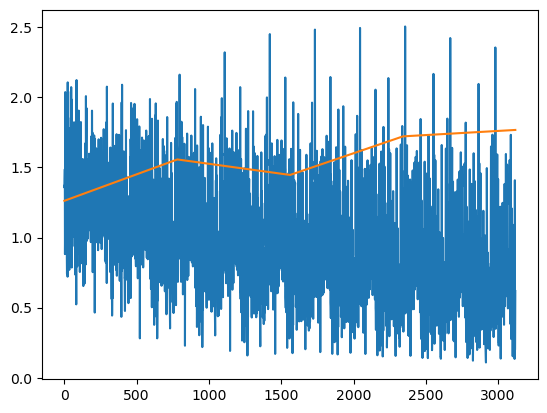

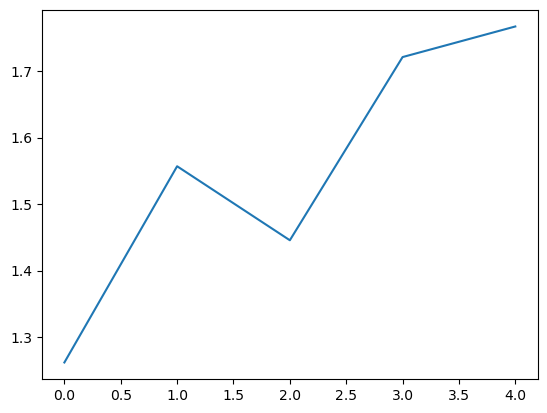

In [ ]:
# Plot the training and validation loss, repeating validation values to match training values
import matplotlib.pyplot as plt
val_lossi_stretched = np.interp(
        np.linspace(0, len(val_lossi) - 1, len(lossi)),
        np.arange(len(val_lossi)),
        val_lossi
    )
plt.plot(lossi)
plt.plot(val_lossi_stretched)
plt.show()

plt.plot(val_lossi)
plt.show()

